In [66]:
%matplotlib inline
#basic python packages for plotting and array management
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

#for data import
import pandas as pd
from __future__ import division
import os
import sys
from importlib import reload
reload(sys)

#Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

#Classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier

#Ensemble methods and crossvalidation
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier,RandomForestClassifier, VotingClassifier

#PostProcessing
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import time

In [2]:
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
X_train = pd.read_csv("X_train.csv")
X_test   = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")

In [3]:
# Preprocessing Products
col = products['SizeAdviceDescription'].eq('Prenez votre pointure habituelle').astype('float')
col1 = products['SizeAdviceDescription'].eq(products['SizeAdviceDescription'][7]).astype('float')
products['SizeAdviceDescription'] = col+col1

In [4]:
# Preprocessing customers
birth = pd.DataFrame(np.zeros((customers.shape[0],1)))
firstorder = pd.DataFrame(np.zeros((customers.shape[0],1)))
le = customers.shape[0]
for i in range (le):
    birth.iloc[i]=2018-int(customers['BirthDate'][i][:4])
    firstorder.iloc[i]=2018-int(customers['FirstOrderDate'][i][:4])
    
customers['BirthDate']=birth
customers['FirstOrderDate']=firstorder

In [4]:
products.head()

,VariantId,GenderLabel,MarketTargetLabel,SeasonLabel,SeasonalityLabel,BrandId,UniverseLabel,TypeBrand,ProductId,ProductType,...,UpperHeight,HeelHeight,PurchasePriceHT,IsNewCollection,SubtypeLabel,UpperMaterialLabel,LiningMaterialLabel,OutSoleMaterialLabel,RemovableSole,SizeAdviceDescription
0,728257.0,Homme,Classique,Automne/Hiver,Saisonnier,66.0,DÃ©tente,Standard,17267.0,Baskets,...,NaN,0.0,30.50,0.0,Montantes,NaN,NaN,NaN,False,0.0
1,806356.0,Femme,ND,Automne/Hiver,Saisonnier,842.0,ND,Standard,30824.0,Baskets,...,0.0,0.0,43.00,0.0,Montantes,NaN,NaN,NaN,True,1.0
2,768790.0,Femme,ND,Automne/Hiver,Reconduit,988.0,Ville,Standard,62475.0,Bottines et boots,...,6.0,3.0,54.90,0.0,Bout pointu,NaN,NaN,NaN,False,1.0
3,515679.0,Femme,ND,Automne/Hiver,Saisonnier,769.0,Ville,Standard,43983.0,Escarpins,...,0.0,13.0,34.50,0.0,Bout rond,NaN,NaN,NaN,False,1.0
4,1025246.0,Femme,ND,Automne/Hiver,Saisonnier,1244.0,ND,Standard,81493.0,Bottines et boots,...,8.0,4.0,43.76,0.0,Bout rond,NaN,NaN,NaN,False,1.0


In [5]:
index = pd.DataFrame({'index':np.arange(X_train.shape[0])})
X_train['index']=index # Evite les duplicata
y_train['index']=index

In [6]:
X_Product = pd.merge(X_train,products,how='left',on='VariantId')
X_data = pd.merge(X_Product,customers,how='left',on='CustomerId')
data = pd.merge(y_train,X_data,how='left',on="index")
data = data.sort_values(by='index')
data.head()

,OrderNumber_x,LineItem_x,ReturnQuantity,ReturnQuantityBin,index,OrderNumber_y,VariantId,LineItem_y,CustomerId,OrderStatusLabel,...,SubtypeLabel,UpperMaterialLabel,LiningMaterialLabel,OutSoleMaterialLabel,RemovableSole,SizeAdviceDescription,CountryISOCode,BirthDate,Gender,FirstOrderDate
0,73521754,1,0.0,0.0,0,73521754,439729,1,12443972,Expédié,...,NaN,NaN,NaN,NaN,NaN,NaN,FR,60.0,Femme,7.0
1,73521754,2,0.0,0.0,1,73521754,440174,2,12443972,Expédié,...,NaN,NaN,NaN,NaN,NaN,NaN,FR,60.0,Femme,7.0
2,73525226,1,1.0,1.0,2,73525226,494501,1,12443958,Expédié,...,Bout rond,NaN,NaN,NaN,False,1.0,FR,46.0,Femme,7.0
3,73529009,1,1.0,1.0,3,73529009,439590,1,12443946,Expédié,...,NaN,NaN,NaN,NaN,NaN,NaN,FR,48.0,Femme,7.0
4,73529009,2,1.0,1.0,4,73529009,559476,2,12443946,Expédié,...,Bout rond,Cuir,NaN,NaN,False,1.0,FR,48.0,Femme,7.0


In [43]:
one = pd.Series(1,index = range(data.shape[0]))
data['one']=one

In [7]:
data.columns.values

array(['OrderNumber_x', 'LineItem_x', 'ReturnQuantity',
       'ReturnQuantityBin', 'index', 'OrderNumber_y', 'VariantId',
       'LineItem_y', 'CustomerId', 'OrderStatusLabel', 'OrderTypelabel',
       'SeasonLabel_x', 'PayementModeLabel', 'CustomerTypeLabel',
       'IsoCode', 'DeviceTypeLabel', 'PricingTypeLabel', 'TotalLineItems',
       'Quantity', 'UnitPMPEUR', 'OrderCreationDate', 'OrderShipDate',
       'OrderNumCustomer', 'IsOnSale', 'BillingPostalCode', 'GenderLabel',
       'MarketTargetLabel', 'SeasonLabel_y', 'SeasonalityLabel', 'BrandId',
       'UniverseLabel', 'TypeBrand', 'ProductId', 'ProductType',
       'SupplierColor', 'ProductColorId', 'MinSize', 'MaxSize', 'CalfTurn',
       'UpperHeight', 'HeelHeight', 'PurchasePriceHT', 'IsNewCollection',
       'SubtypeLabel', 'UpperMaterialLabel', 'LiningMaterialLabel',
       'OutSoleMaterialLabel', 'RemovableSole', 'SizeAdviceDescription',
       'CountryISOCode', 'BirthDate', 'Gender', 'FirstOrderDate'], dtype=object)

In [44]:
returndata = data[data['ReturnQuantityBin']==1]

In [124]:
def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%f' %height,
                ha='center', va='bottom')

def histogramme (column):
    d = pd.crosstab(data['one'],data[column],normalize='index')
    returnd = pd.crosstab(returndata['one'],returndata[column],normalize='index')
    label = d.columns.tolist()
    liste1 = d.values[0]
    liste2 = returnd.values[0]
    # Plot the scores
    N = len(label)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    sns.set(style='darkgrid')
    fig, ax = plt.subplots(figsize=(20, 10))

    rects1 = ax.bar(ind, liste1, width, color='indianred')
    rects2 = ax.bar(ind + width, liste2, width, color='seagreen')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Ratio')
    ax.set_title('Ratio for data and returned data')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(label,rotation=90)
    ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))
    
    autolabel(rects1)
    autolabel(rects2)

    plt.show()

## Products

##### Price HT

In [64]:
print('pour les prix entre 0 et 20€')
# Pour toutes les données
price020 = ((data['PurchasePriceHT']>0) & (data['PurchasePriceHT']<20)).sum()/(data.shape[0])
print(price020)

# Pour les données retournées
price020return = ((returndata['PurchasePriceHT']>0) & (returndata['PurchasePriceHT']<20)).sum()/(returndata.shape[0])
print(price020return)

print('\npour les prix entre 20 et 40€')
# Pour toutes les données
price = ((data['PurchasePriceHT']>20) & (data['PurchasePriceHT']<40)).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['PurchasePriceHT']>20) & (returndata['PurchasePriceHT']<40)).sum()/(returndata.shape[0])
print(pricereturn)

print('\npour les prix entre 40 et 60€')
# Pour toutes les données
price = ((data['PurchasePriceHT']>40) & (data['PurchasePriceHT']<60)).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['PurchasePriceHT']>40) & (returndata['PurchasePriceHT']<60)).sum()/(returndata.shape[0])
print(pricereturn)

print('\npour les prix entre 60 et 80€')
# Pour toutes les données
price = ((data['PurchasePriceHT']>60) & (data['PurchasePriceHT']<80)).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['PurchasePriceHT']>60) & (returndata['PurchasePriceHT']<80)).sum()/(returndata.shape[0])
print(pricereturn)

pour les prix entre 0 et 20€
0.155964170938
0.128892858432

pour les prix entre 20 et 40€
0.295360211376
0.30245660568

pour les prix entre 40 et 60€
0.133006961557
0.152421421096

pour les prix entre 60 et 80€
0.0341912694769
0.0433988307892


##### SeasonLabel

In [17]:
# Pour toutes les données
d = ((data['SeasonLabel_x'] == 'Automne/Hiver').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['SeasonLabel_x'] == 'Automne/Hiver').sum())/(returndata.shape[0])
print(dreturn)

0.444673893693
0.455599761827


##### GenderLabel

In [19]:
print('femme')
# Pour toutes les données
d = ((data['GenderLabel'] == 'Femme').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['GenderLabel'] == 'Femme').sum())/(returndata.shape[0])
print(dreturn)

print('\nhomme')
# Pour toutes les données
d = ((data['GenderLabel'] == 'Homme').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['GenderLabel'] == 'Homme').sum())/(returndata.shape[0])
print(dreturn)

print('\nenfant')
# Pour toutes les données
d = ((data['GenderLabel'] == 'Enfant').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['GenderLabel'] == 'Enfant').sum())/(returndata.shape[0])
print(dreturn)

femme
0.350230958783
0.427812962362

homme
0.144029270395
0.111476489481

enfant
0.131143363097
0.112486918552


###### Size advice description

In [15]:
# Pour toutes les données
d = ((data['SizeAdviceDescription'] == 1).sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['SizeAdviceDescription'] == 1).sum())/(returndata.shape[0])
print(dreturn)

0.40445989375
0.406142867453


###### UniverseLabel

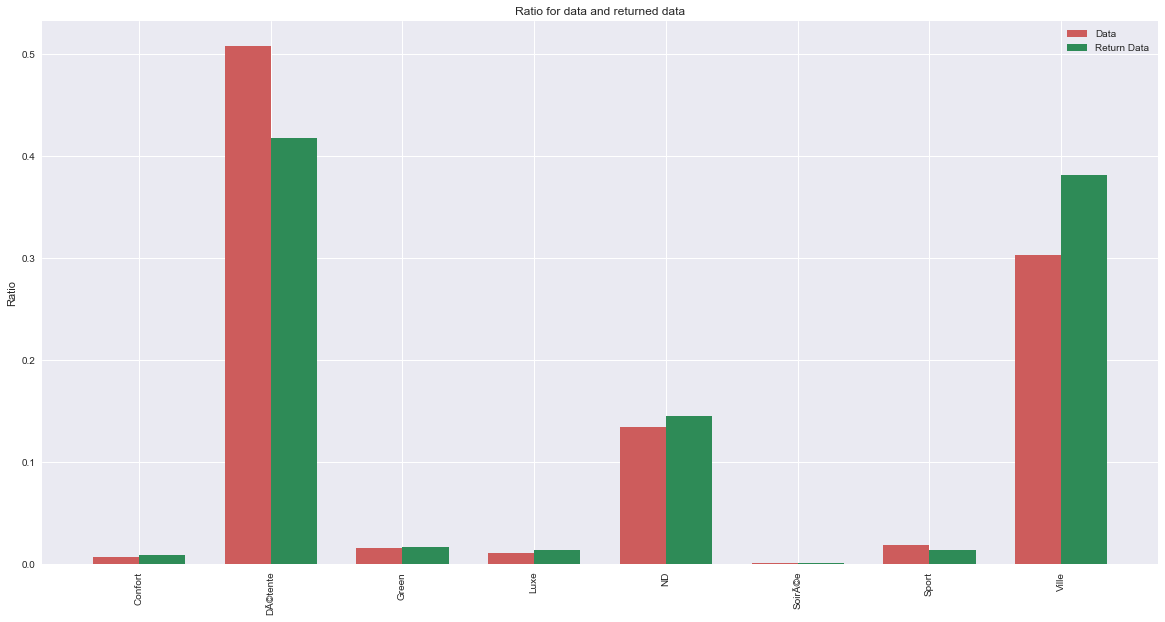

In [133]:
histogramme('UniverseLabel')

###### Product Type

In [105]:
d = pd.crosstab(data['one'],data['ProductType'],normalize='index')
#d.iloc[0].plot.bar()
print(d.columns.tolist)
print(d.shape)
print(d.values[0])

<bound method Index.tolist of Index(['Bagages', 'Ballerines', 'Baskets', 'Bottes', 'Bottines et boots',
       'Business', 'Ceintures', 'Chaussettes et collants', 'Chaussons',
       'Chaussures de sport', 'Chaussures Ã  lacets', 'Chaussures Ã  scratch',
       'Divers', 'Escarpins', 'Espadrilles', 'Isotherme', 'Lacets',
       'Mocassins', 'Mules et sabots', 'Petite Maroquinerie',
       'Produits d'entretien', 'Sacs de sport', 'Sacs homme',
       'Sacs ordinateur', 'Sacs pochettes', 'Sacs Ã  dos', 'Sacs Ã  main',
       'Sandales et nu-pieds', 'Scolaire', 'Semelles', 'Tongs'],
      dtype='object', name='ProductType')>
(1, 31)
[  7.01403097e-04   7.73624333e-02   2.63491823e-01   4.64293926e-02
   1.35580346e-01   1.55705667e-04   3.59432708e-04   4.05998888e-04
   1.11103997e-02   5.78599347e-02   5.85642482e-02   8.37027099e-03
   5.38421465e-05   7.05695917e-02   8.08068755e-03   7.13044642e-05
   7.69797175e-04   2.59460938e-02   1.35769521e-02   2.87837205e-03
   5.84987645e-03

In [104]:
returnd = pd.crosstab(returndata['one'],returndata['ProductType'],normalize='index')

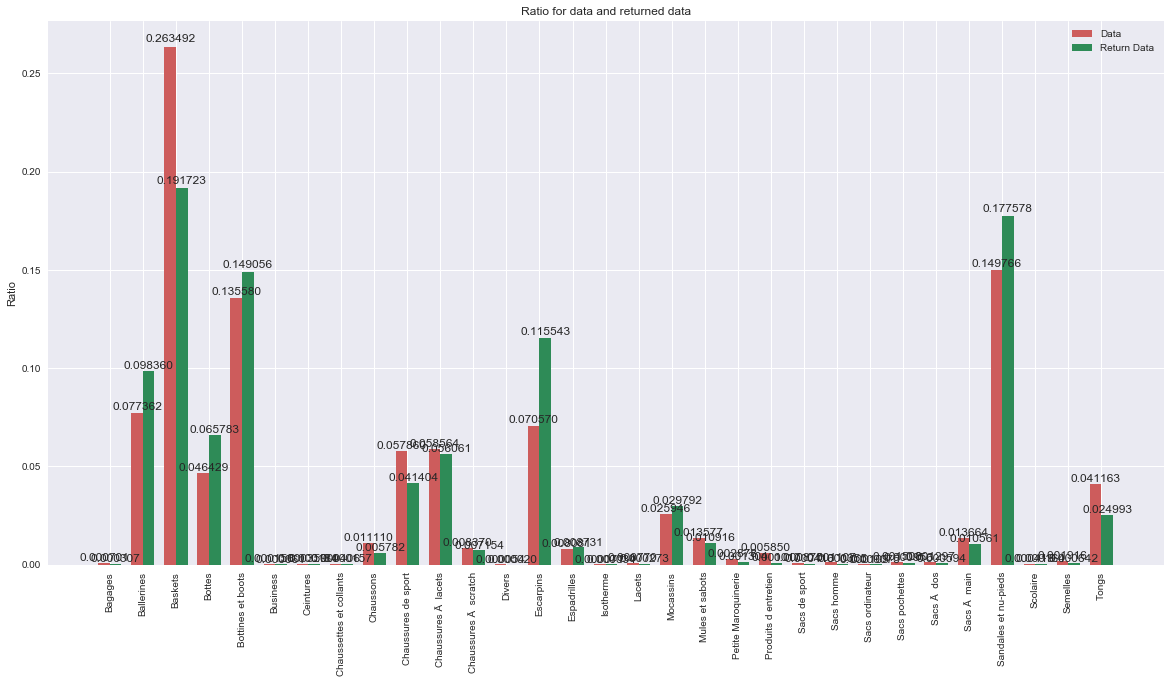

In [109]:
# Plot the scores
N = d.shape[1]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(ind, d.values[0], width, color='indianred')
rects2 = ax.bar(ind + width, returnd.values[0], width, color='seagreen')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ratio')
ax.set_title('Ratio for data and returned data')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Bagages', 'Ballerines', 'Baskets', 'Bottes', 'Bottines et boots',
       'Business', 'Ceintures', 'Chaussettes et collants', 'Chaussons',
       'Chaussures de sport', 'Chaussures Ã  lacets', 'Chaussures Ã  scratch',
       'Divers', 'Escarpins', 'Espadrilles', 'Isotherme', 'Lacets',
       'Mocassins', 'Mules et sabots', 'Petite Maroquinerie',
       'Produits d entretien', 'Sacs de sport', 'Sacs homme',
       'Sacs ordinateur', 'Sacs pochettes', 'Sacs Ã  dos', 'Sacs Ã  main',
       'Sandales et nu-pieds', 'Scolaire', 'Semelles', 'Tongs'],rotation=90)
ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%f' %height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

# Customers

##### FirstOrderDate

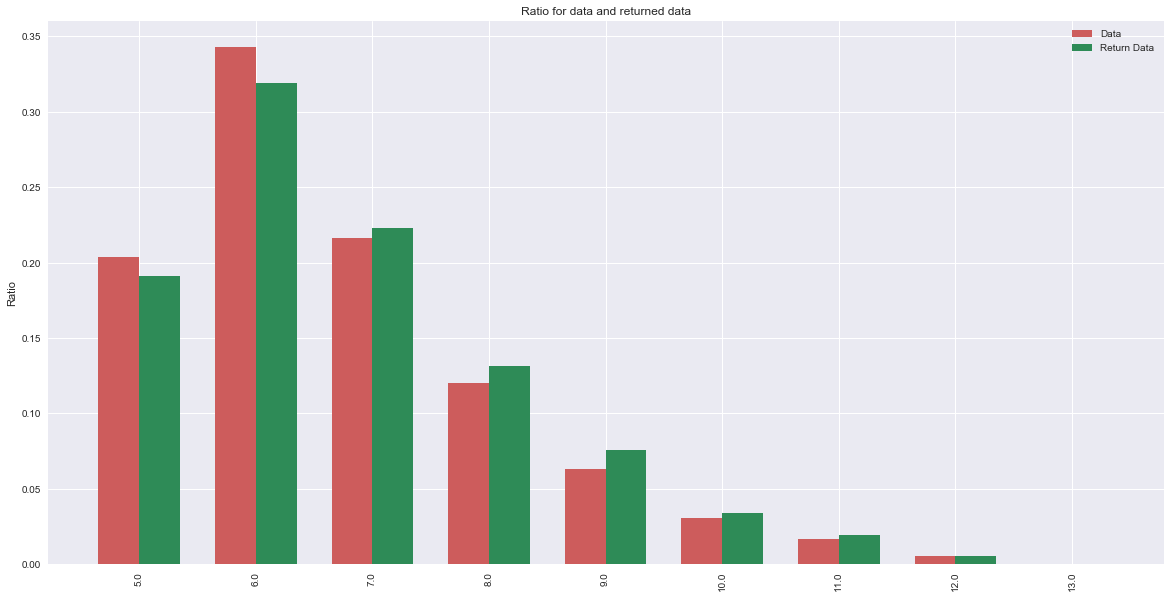

In [134]:
histogramme('FirstOrderDate')

##### Modification age/orderdate

In [24]:
customers.head()

,CustomerId,CountryISOCode,BirthDate,Gender,FirstOrderDate
0,14089083.0,SE,1979-02-05 00:00:00,Femme,2013-03-16 23:00:05
1,12862066.0,FR,1982-08-04 00:00:00,Femme,2012-02-14 17:47:33
2,14791699.0,FR,1965-04-02 00:00:00,Femme,2013-10-04 23:10:42
3,10794664.0,FR,1966-04-09 00:00:00,Femme,2010-03-25 18:46:59
4,15268576.0,ES,1980-04-22 00:00:00,Femme,2014-03-19 10:48:39


###### Age

In [8]:
age1015 = (data['BirthDate']>10) & (data['BirthDate']<15)
age1520 = (data['BirthDate']>15) & (data['BirthDate']<20)
age2025 = (data['BirthDate']>20) & (data['BirthDate']<25)
age2530 = (data['BirthDate']>25) & (data['BirthDate']<30)
age3035 = (data['BirthDate']>30) & (data['BirthDate']<35)
age3540 = (data['BirthDate']>35) & (data['BirthDate']<40)
age4045 = (data['BirthDate']>40) & (data['BirthDate']<45)
age4550 = (data['BirthDate']>45) & (data['BirthDate']<50)
age5055 = (data['BirthDate']>50) & (data['BirthDate']<55)
age5560 = (data['BirthDate']>55) & (data['BirthDate']<60)
    
age = [age1015,age1520,age2025,age2530,age3035,age3540,age4045,age4550,age5055,age5560]

returnage1015 = (returndata['BirthDate']>10) & (returndata['BirthDate']<15)
returnage1520 = (returndata['BirthDate']>15) & (returndata['BirthDate']<20)
returnage2025 = (returndata['BirthDate']>20) & (returndata['BirthDate']<25)
returnage2530 = (returndata['BirthDate']>25) & (returndata['BirthDate']<30)
returnage3035 = (returndata['BirthDate']>30) & (returndata['BirthDate']<35)
returnage3540 = (returndata['BirthDate']>35) & (returndata['BirthDate']<40)
returnage4045 = (returndata['BirthDate']>40) & (returndata['BirthDate']<45)
returnage4550 = (returndata['BirthDate']>45) & (returndata['BirthDate']<50)
returnage5055 = (returndata['BirthDate']>50) & (returndata['BirthDate']<55)
returnage5560 = (returndata['BirthDate']>55) & (returndata['BirthDate']<60)
    
returnage = [returnage1015,returnage1520,returnage2025,returnage2530,returnage3035,returnage3540,returnage4045,returnage4550,returnage5055,returnage5560]

ratio = []
ratioreturn = []
for j in range (len(ratio)):
    #print('\nAge du consomateur entre :%f et %f',%(10+5*j) %(10+5*(j+1)))
    ratio.append(age[j].sum()/(data.shape[0]))
    ratioreturn.append(returnage[j].sum()/(returndata.shape[0]))

10


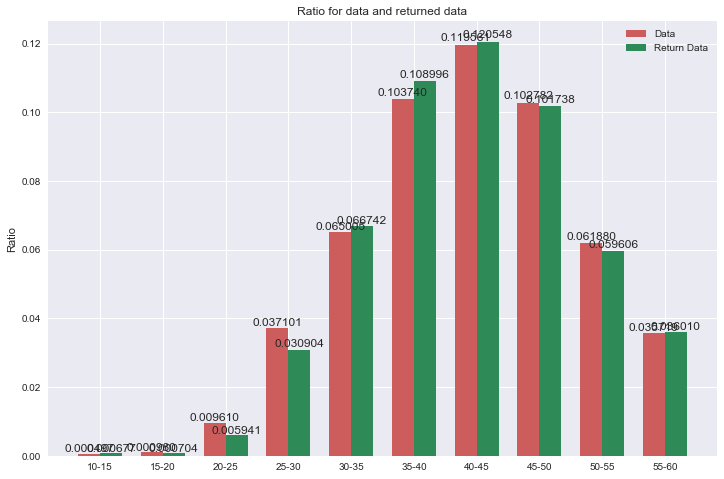

In [11]:
# Plot the scores
N = len(ratio)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(ind, ratio, width, color='indianred')
rects2 = ax.bar(ind + width, ratioreturn, width, color='seagreen')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ratio')
ax.set_title('Ratio for data and returned data')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('10-15', '15-20', '20-25', '25-30','30-35','35-40','40-45','45-50','50-55','55-60'))
ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%f' %height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

##### Country ISO CODE

In [16]:
pd.crosstab(data['Gender'],data['CountryISOCode'],normalize='columns')

CountryISOCode,AT,BE,BG,CZ,DE,DK,EE,ES,FI,FR,...,LT,LU,LV,NL,PL,PT,RO,SE,SI,SK
Gender,,,,,,,,,,,,,,,,,,,,,
Femme,0.72679,0.836421,0.863636,0.980198,0.801984,0.801681,0.92,0.764643,0.880478,0.820193,...,0.9,0.869467,0.85,0.823275,0.832692,0.785714,0.72973,0.736024,0.657143,0.694444
Homme,0.27321,0.163579,0.136364,0.019802,0.198016,0.198319,0.08,0.235357,0.119522,0.179804,...,0.1,0.130533,0.15,0.176725,0.167308,0.214286,0.27027,0.263976,0.342857,0.305556
NC,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000003,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [17]:
pd.crosstab(returndata['Gender'],returndata['CountryISOCode'],normalize='columns')

CountryISOCode,AT,BE,BG,CZ,DE,DK,EE,ES,FI,FR,...,LT,LU,LV,NL,PL,PT,RO,SE,SI,SK
Gender,,,,,,,,,,,,,,,,,,,,,
Femme,0.759615,0.88563,1.0,1.0,0.84154,0.859784,1.0,0.810058,0.931818,0.862718,...,1.0,0.89759,0.666667,0.873645,0.85614,0.75,0.5,0.775322,1.0,0.5
Homme,0.240385,0.11437,0.0,0.0,0.15846,0.140216,0.0,0.189942,0.068182,0.137275,...,0.0,0.10241,0.333333,0.126355,0.14386,0.25,0.5,0.224678,0.0,0.5
NC,0.000000,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000007,...,0.0,0.00000,0.000000,0.000000,0.00000,0.00,0.0,0.000000,0.0,0.0


Peu importe le pays, les femmes sont toujours celles qui renvoient le plus les commandes. Information inutile dans CountryISOCode ?

###### Gender

In [16]:
print('homme')
# Pour toutes les données
d = ((data['Gender'] == 'Homme').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['Gender'] == 'Homme').sum())/(returndata.shape[0])
print(dreturn)

print('\nfemme')
# Pour toutes les données
d = ((data['Gender'] == 'Femme').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['Gender'] == 'Femme').sum())/(returndata.shape[0])
print(dreturn)

homme
0.135259395291
0.102914907437

femme
0.605318142211
0.635090758183


# Orders

##### Customer type label

In [75]:
print('fidélisé')
# Pour toutes les données
d = ((data['CustomerTypeLabel'] == 'Fidélisé').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['CustomerTypeLabel'] == 'Fidélisé').sum())/(returndata.shape[0])
print(dreturn)

print('\nnouveau')
# Pour toutes les données
d = ((data['CustomerTypeLabel'] == 'Nouveau').sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['CustomerTypeLabel'] == 'Nouveau').sum())/(returndata.shape[0])
print(dreturn)

fidélisé
0.576905995559
0.616560210747

nouveau
0.423094004441
0.383439789253


In [10]:
print('femmes fidélisées')
# Pour toutes les données
price = ((data['CustomerTypeLabel'] == 'Fidélisé') & (data['Gender'] == 'Femme')).sum()/(data.shape[0])
print(price)
#price = ((data['CustomerTypeLabel'] == 'Nouveau') & (data['Gender'] == 'Femme')).sum()/(data.shape[0])
#print(price)

# Pour les données retournées
pricereturn = ((returndata['CustomerTypeLabel'] == 'Fidélisé') & (returndata['Gender'] == 'Femme')).sum()/(returndata.shape[0])
print(pricereturn)

femmes fidélisées
0.38333255254
0.423211901411


In [73]:
print('hommes non fidélisées')
# Pour toutes les données
price = ((data['CustomerTypeLabel'] == 'Nouveau') & (data['Gender'] == 'Homme')).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['CustomerTypeLabel'] == 'Nouveau') & (returndata['Gender'] == 'Homme')).sum()/(returndata.shape[0])
print(pricereturn)

hommes non fidélisées
0.0722802612223
0.0513153621306


In [22]:
pd.crosstab(data['Gender'],data['CustomerTypeLabel'],normalize='all')

CustomerTypeLabel,Fidélisé,Nouveau
Gender,,
Femme,0.517612,0.299746
Homme,0.085040,0.097600
NC,0.000003,0.000000


In [23]:
pd.crosstab(returndata['Gender'],returndata['CustomerTypeLabel'],normalize='all')

CustomerTypeLabel,Fidélisé,Nouveau
Gender,,
Femme,0.573450,0.287095
Homme,0.069917,0.069532
NC,0.000006,0.000000


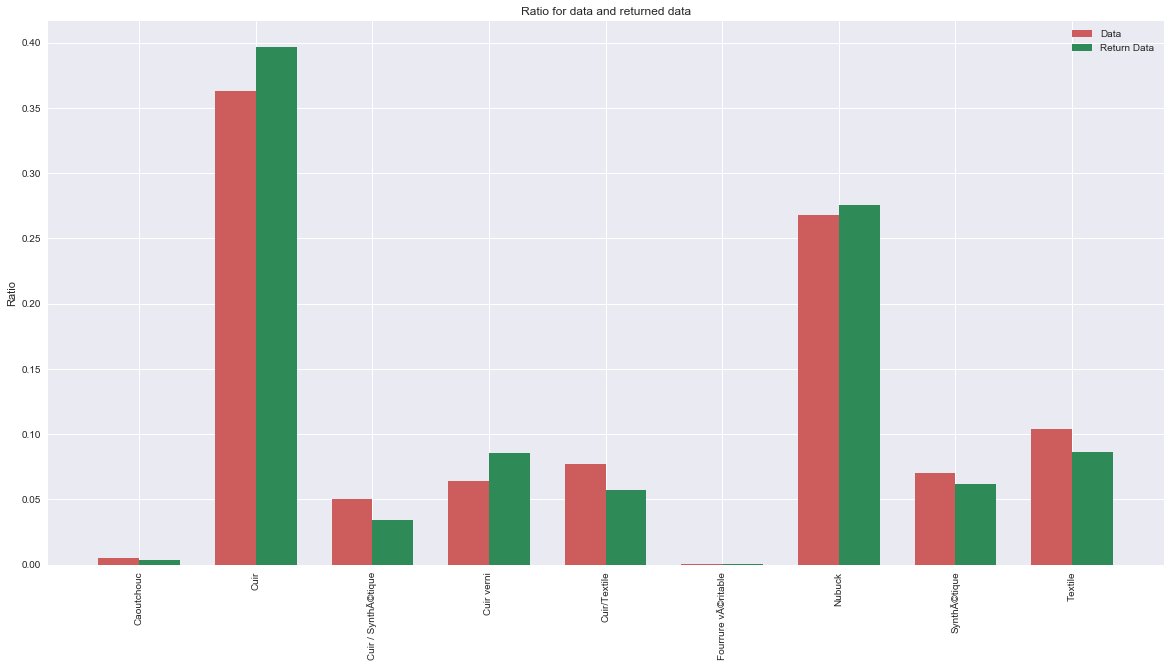

In [152]:
histogramme('UpperMaterialLabel')